# Emperical experiment for StreamingCNN
To evaluate whether a neural network using streaming trains equivalently to the conventional training, we can train a CNN on small images using both methods, starting from the same initialization. We used a subset of the ImageNet dataset, ImageNette, using 100 examples of 10 ImageNet classes (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [1]:
import os
import copy
import random
from typing import Any
import pandas as pd

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional
from lightstream.modules.imagenet_template import ImageNetClassifier

from lightning.pytorch import Trainer
from lightning.pytorch import LightningModule
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.utilities.types import STEP_OUTPUT

from PIL import Image
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
torch.set_printoptions(precision=10)
torch.manual_seed(0)

In [3]:
# to compare the networks we want to train deterministically
torch.backends.cudnn.deterministic = True

# Download the dataset

In [4]:
if not os.path.isfile('imagenette2-320.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
    !tar -xvf imagenette2-320.tgz

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2024-03-27 10:57:42--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.194.232, 52.217.199.152, 54.231.236.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.194.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: 'imagenette2-320.tgz'

imagenette2-320.tgz 100%[===================>] 325.83M  16.1MB/s    in 15s     

2024-03-27 10:57:59 (21.0 MB/s) - 'imagenette2-320.tgz' saved [341663724/341663724]

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
imagenette2-320/
imagenette2-320/train/
imagenette2-320/noisy_imagenette.csv
imagenette2-320/val/
imagenette2-320/val/n03394916/
imagenette2-320/val/n03417042/
imagenette2-320/val/n03445777/
imagenette2-320/val/n02102040/
imagenette2-320/val/n03425413/
imagenette2-320/val/n03888257/
image

# Model definition

In [5]:
class StreamNet(torch.nn.Sequential):
    def __init__(self):
        super(StreamNet, self).__init__(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveMaxPool2d(1)
        )

        self.classifier = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [7]:
class Classifier(LightningModule):
    def __init__(self):
        super().__init__()
        self.stream_net = StreamNet()
        self.net = Net()
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.stream_net(x)
        logit = self.net(out)
        return logit
    
    def training_step(self, batch, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        logits = self.forward(image)
        loss = self.loss_fn(logits, target)

        output = {}

        output["train_loss"] = loss

        self.log_dict(output, prog_bar=True, on_step=False,  on_epoch=True, sync_dist=True,)
        return loss
    
    def validation_step(self, batch, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        logits = self.forward(image)
        loss = self.loss_fn(logits, target)

        output = {}

        output["val_loss"] = loss

        self.log_dict(output, prog_bar=True, on_step=False,  on_epoch=True, sync_dist=True,)
        
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt

# Configure networks


In [8]:
#sCNN = StreamingCNN(stream_net, tile_shape=(1, 3, 32, 32), deterministic=True, verbose=True)
stream_net = StreamNet()
net = Net()

In [9]:
for mod in net.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(mod.weight, nonlinearity='relu')
        mod.bias.data.fill_(0)
        
# save parameters so that we can start networks from the same initialization
original_initialization_stream_net = copy.deepcopy(stream_net.state_dict())
original_initialization_net = copy.deepcopy(net.state_dict())



In [10]:
stream_model = ImageNetClassifier(stream_net, net, tile_size=64, loss_fn= torch.nn.CrossEntropyLoss(), train_streaming_layers=True, metrics=None, deterministic=True, verbose=False)
stream_model = stream_model.to("cuda")
stream_model.stream_network.stream_module.load_state_dict(original_initialization_stream_net)
stream_model.head.load_state_dict(original_initialization_net)

No tile cache found, calculating it now

Converting modules to nn.Identity()
Executing pre-streaming initialization callbacks (if any):

Initializing streaming model
testing shape gradient fix
testing shape gradient fix
Restoring model weights
Executing post-streaming initialization callbacks (if any):

writing streaming cache file to /tmp/pycharm_project_179/notebooks/tile_cache_1_3_64_64


<All keys matched successfully>

# Create Dataloaders

In [11]:
class ImagenetteDataset(object):
    def __init__(self, patch_size=320, validation=False, should_normalize=True):
        self.folder = Path('imagenette2-320/train') if not validation else Path('imagenette2-320/val')
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                        'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

        self.images = []
        for cls in self.classes:
            cls_images = list(self.folder.glob(cls + '/*.JPEG'))
            self.images.extend(cls_images)
        
        self.patch_size = patch_size
        self.validation = validation
        
        self.random_resize = torchvision.transforms.RandomResizedCrop(patch_size)
        self.center_resize = torchvision.transforms.CenterCrop(patch_size)
        self.should_normalize = should_normalize
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __getitem__(self, index):
        image_fname = self.images[index]
        image = Image.open(image_fname)
        label = image_fname.parent.stem
        label = self.classes.index(label)
        
        if not self.validation: image = self.random_resize(image)
        else: image = self.center_resize(image)
            
        image = torchvision.transforms.functional.to_tensor(image)
        if image.shape[0] == 1: image = image.expand(3, 320, 320)
        if self.should_normalize: image = self.normalize(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [12]:
trainset = ImagenetteDataset(320)
valset = ImagenetteDataset(320, validation=True)

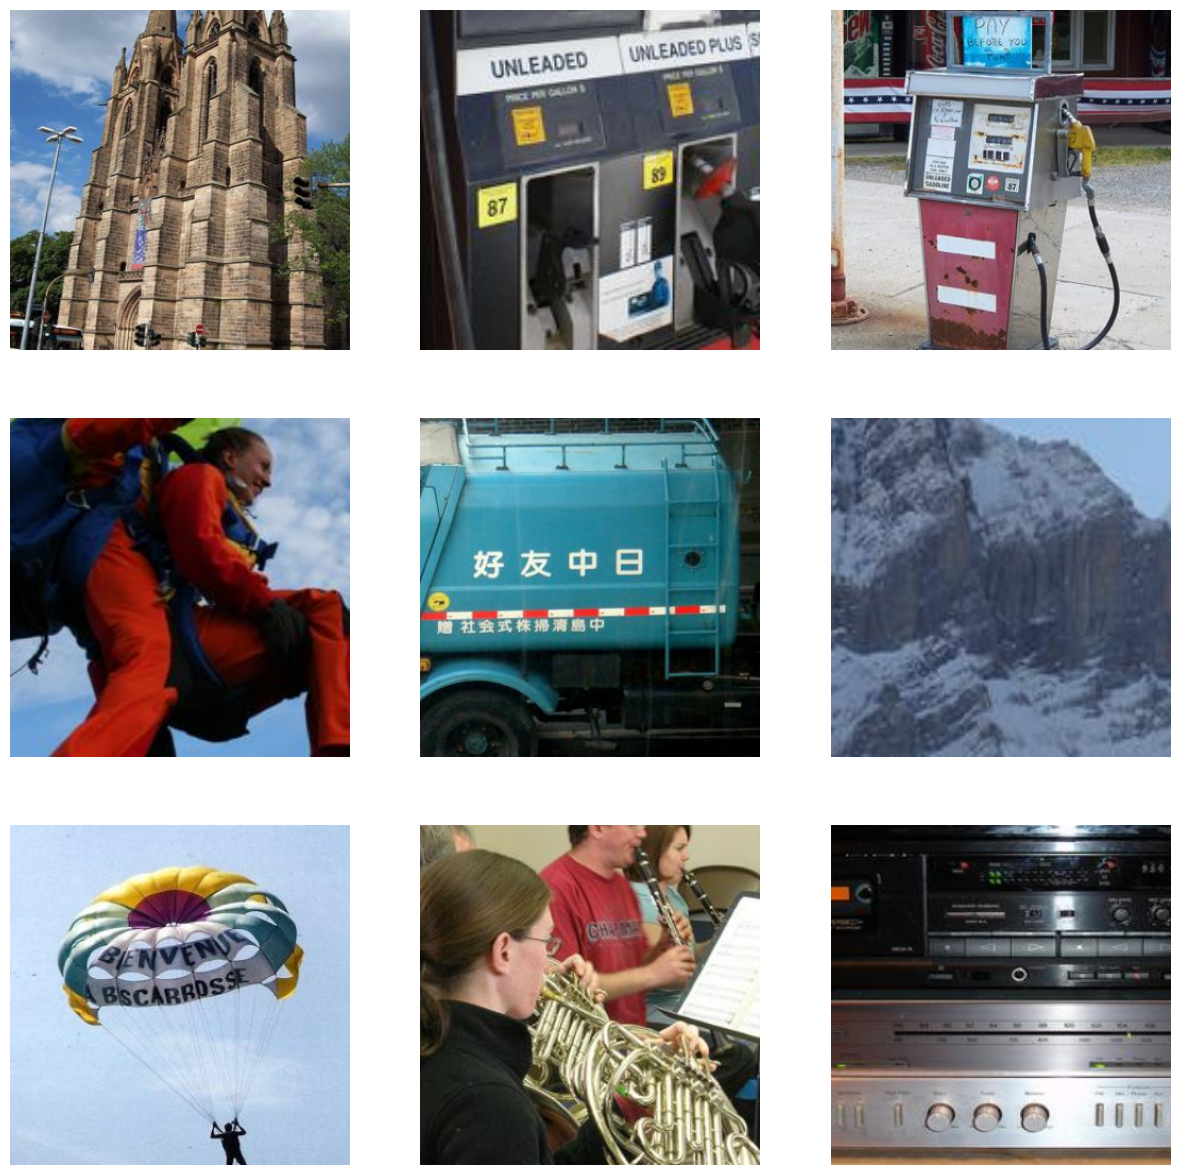

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
visualize_trainset = ImagenetteDataset(320, should_normalize=False)

for y in range(3):
    for x in range(3):
        index = random.randint(0, len(trainset) - 1)
        sample = visualize_trainset[index]
        ax[y, x].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x].set_axis_off()

plt.show(); 

# Initialize network and optimizer


In [14]:
# save parameters so that we can start networks from the same initialization
original_initialization_stream_net = copy.deepcopy(stream_net.state_dict())
original_initialization_net = copy.deepcopy(net.state_dict())

In [15]:
batch_size = 32
#torch.backends.cudnn.deterministic = True
#torch.use_deterministic_algorithms(True, warn_only=True)

# Train normal

In [16]:
seed_everything(0)
normal_model = Classifier()
normal_model = normal_model.to("cuda")
normal_model.stream_net.load_state_dict(original_initialization_stream_net)
normal_model.net.load_state_dict(original_initialization_net)
csv_logger = CSVLogger(
    save_dir='./',
    name='csv_file_normal'
)

# Initialize a trainer
trainer = Trainer(
    accelerator="auto",
    max_epochs=15,
    log_every_n_steps=10,
    logger=[csv_logger],
    deterministic='warn'
)

torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=6)
trainer.fit(normal_model, train_dataloaders=trainloader, val_dataloaders=valloader)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./csv_file_normal
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | stream_net | StreamNet        | 5.1 K 
1 | net        | Net              | 390 K 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.581     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


# Train Streaming


In [17]:
seed_everything(0)

stream_model = ImageNetClassifier(stream_net, net, tile_size=64, loss_fn= torch.nn.CrossEntropyLoss(), train_streaming_layers=True, metrics=None, deterministic=True, verbose=False, mean=[0., 0., 0.], std=[1., 1., 1.], copy_to_gpu=True)
stream_model = stream_model.to("cuda")
stream_model.stream_network.stream_module.load_state_dict(original_initialization_stream_net)
stream_model.head.load_state_dict(original_initialization_net)

csv_logger = CSVLogger(
    save_dir='./',
    name='csv_file_streaming'
)

# Initialize a trainer
trainer = Trainer(
    accelerator="auto",
    max_epochs=15,
    log_every_n_steps=10,
    logger=[csv_logger],
    deterministic='warn'
)

torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=6)
trainer.fit(stream_model, train_dataloaders=trainloader, val_dataloaders=valloader)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./csv_file_streaming
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | stream_network | StreamingCNN     | 5.1 K 
1 | head           | Net              | 390 K 
2 | loss_fn        | CrossEntropyLoss | 0     
----------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.581     Total estimated model params size (MB)


Loading tile cache from /tmp/pycharm_project_179/notebooks/tile_cache_1_3_64_64
previous tile cache found and overwrite is false, not saving


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


<Axes: >

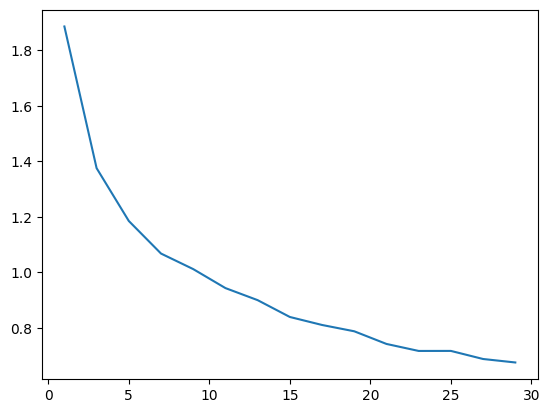

In [18]:
df_streaming = pd.read_csv("./csv_file_streaming/version_0/metrics.csv")
df_streaming['train_loss'].dropna().plot.line()


<Axes: >

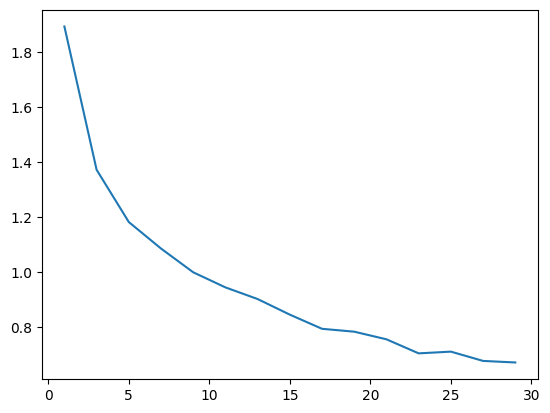

In [19]:
df_normal = pd.read_csv("./csv_file_normal/version_0/metrics.csv")
df_normal['train_loss'].dropna().plot.line()